Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Binary Classifier Performance Measurement

The classification of observations into just two categories is a special case of the broader array of applications that involve predicting three or more ordered or unordered target variable labels.  And, there are many different performance metrics used in several different disciplines.

# Confusion Matrix

Many frequently used binary classifier performance metrics are based on the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which is basically just a cross-tabulation of true vs. predicted class labels.

Other common measures include the _Area Under the Curve_ (AUC), where the curve is a _Receiver Operating Characteristic_ (ROC) curve.

Let's get the data and results from the binary logistic regression notebook, and apply some performance metrics to it.

But first we need to get lots of stuff in modules:

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
import pickle
import os
import shelve
%matplotlib inline

#  Unpickling the Data

This assumes that the pickle file is in the DATA subdir.

In [5]:
with open('rBinLogData99.pkl','rb') as pickleInFile:
    breastResDict=pickle.load(pickleInFile)
breastResDict.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'yTestPredLabels', 'yTestPredProbs', 'yTrainPredLabels', 'yTrainPredProbs'])

# Basic Confusion

A _confusion matrix_ is basically just a two-way table tabulating comments of "true" classifier label values by "predicted" labels.

In [10]:
## Training Data Confusion Matrix

print(confusion_matrix(breastResDict['y_train'], breastResDict['yTrainPredLabels']))

[[260   7]
 [  9 150]]


In [11]:
# Test Data Confusion Matrix

print(confusion_matrix(breastResDict['y_test'], breastResDict['yTestPredLabels']))

[[84  6]
 [ 3 50]]


# Kinder Confusion

#Let's import a script for a "better looking" confusion matrix from [Matt Hancock](https://notmatthancock.github.io/2015/10/28/confusion-matrix.html), It's in the file `show-confusion.py`.  

Assuming that it's in the pwd:
 

In [12]:
%%writefile show_confusion.py

def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()




Writing show_confusion.py


In [13]:
from show_confusion import show_confusion_matrix

In [14]:
print(show_confusion_matrix.__doc__)


    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    


<strong>Training Data Confusion Matrix</strong><br/>

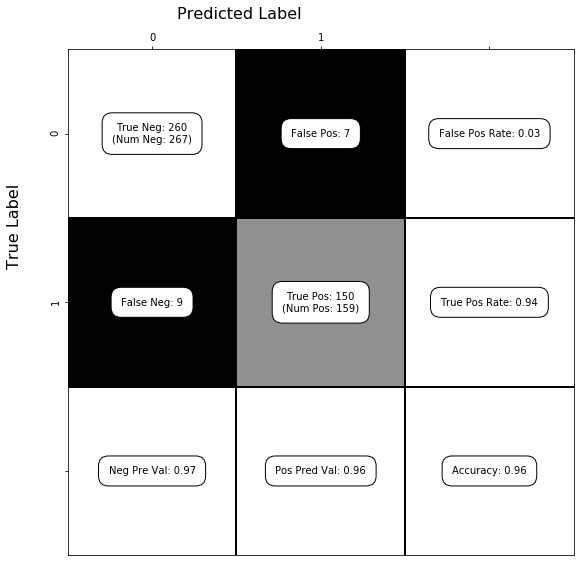

In [15]:
Markdown('<strong>{}</strong><br/>'.format("Training Data Confusion Matrix"))

show_confusion_matrix(confusion_matrix(breastResDict['y_train'], 
                                       breastResDict['yTrainPredLabels']))


<strong>Test Data Confusion Matrix</strong><br/>

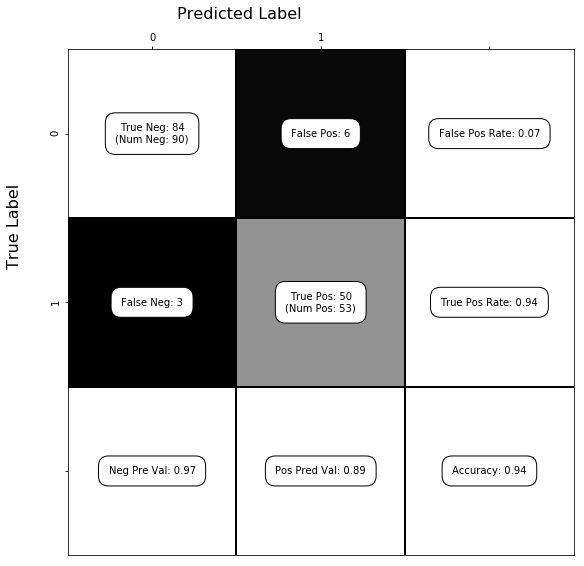

In [16]:
Markdown('<strong>{}</strong><br/>'.format("Test Data Confusion Matrix"))

show_confusion_matrix(confusion_matrix(breastResDict['y_test'], 
                                       breastResDict['yTestPredLabels']))


# A Few Useful Binary Classifier Scores  

Scikit-learn provide a number of [metrics for classifiers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). Among these are:

* AUC - area under the ROC ("receiver operating characteristics") curve.
* Precision (AKA positive predictive value).
* Recall (AKA sensitivity).
* F1 (harmonic mean of Precision and Recall).
* Accuracy (proportion correct).
* Hit Rate (AKA sensitivity).
* False Alarm Rate (1-selectivity).

This page on [wikipedia about Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) includes a table that's helpful in disambiguating the terminology above.

![Presicion and Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png)
The Hit Rate (HR) and the False Alarm Rate (FAR) are used to plot an ROC curve.

# ROC Curve and AUC

Let's first get the data out of the dict breastResDict to make things more convenient.

In [21]:
y_train=breastResDict['y_train']
y_test=breastResDict['y_test']
yTrainPredProbs=breastResDict['yTrainPredProbs']
yTestPredProbs=breastResDict['yTestPredProbs']

In [28]:
# Just checking

yTrainPredProbs.shape
yTestPredProbs.shape

pd.DataFrame(y_train).tail()
pd.DataFrame(yTrainPredProbs).tail()

(426, 2)

(143, 2)

,0
421,1
422,0
423,1
424,0
425,0


,0,1
421,5.857352e-01,0.414265
422,9.942723e-01,0.005728
423,2.751098e-08,1.000000
424,9.731066e-01,0.026893
425,6.396186e-01,0.360381


## ROC Plot and AUC for the Training Data

In [23]:
# Plotting using maplotlib, a "reusable" ROC plotting fcn

def plotROC(fpr,tpr,label=None):
    plt.subplots(figsize=(6,6))
    plt.plot(fpr,tpr, linewidth=3,label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Pos Rate')
    plt.ylabel('True Pos Rate')


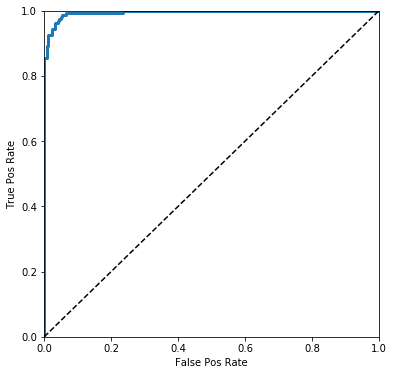

In [29]:
# For the Training data results

fprTrain, tprTrain, _ = roc_curve(y_train, yTrainPredProbs[:,1])

plotROC(fprTrain, tprTrain)
plt.show()

In [31]:
trainingAUC=roc_auc_score(y_train, yTrainPredProbs[:,1])
print('Training AUC: {0:4.3f}'.format(trainingAUC))

Training AUC: 0.995


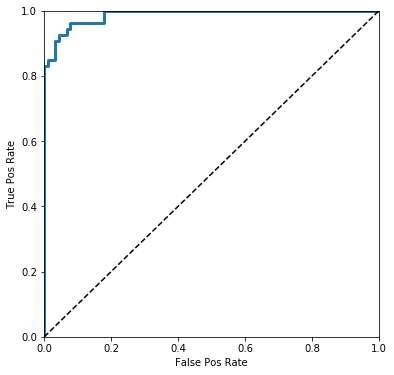

In [32]:
# For the Test data results

fprTest, tprTest, _ = roc_curve(y_test, yTestPredProbs[:,1])

plotROC(fprTest, tprTest)
plt.show()

In [33]:
testAUC=roc_auc_score(y_test, yTestPredProbs[:,1])
print('Test AUC: {0:4.3f}'.format(testAUC))

Test AUC: 0.988


## Zounds!  What a Fit!

This model works too well.  Suspiciously so, in fact.  To get a sense of what typical ROC's look like, do the following UDU.

# UDU: Train a Binary Logistic Classifier Using Features of Your Choice

Pick out just a couple of features, and train a binary logistic classifier using them. Use a hold out validation sample as your test data.  Then, plot ROCs for results based on your training data and your test data.

The scikit-learn method [model_selection.cross_val_precict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) can be used to "quickly" get predictions from a cross-validated model. Give it a try, here.

## Alternative Ways to Do an ROC Plot  

There's more than one way to do it, even if it isn't in Perl.  The [scikit-plot](https://scikit-plot.readthedocs.io/en/stable/) package has some clever ways of producing plot to assess classifiers and other kinds of models.  Here's a set-up for using it with the logistic results, above.

`scikit-plot` likes a 2D numpy array for the predicted label probabilities:

In [40]:
#yTestProbs=np.c_[1-yTestPredProbs,yTestPredProbs]
yTestProbs=yTestPredProbs

Then we can do:

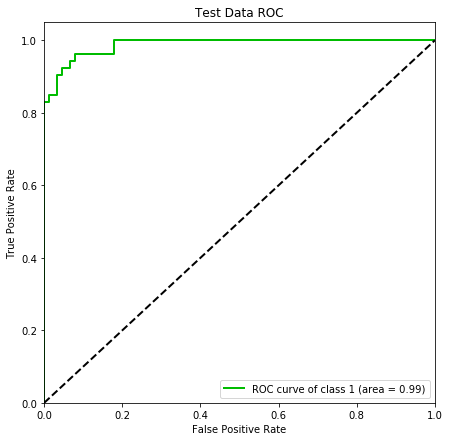

In [41]:
skplt.metrics.plot_roc(y_test, yTestProbs, title="Test Data ROC",
                      figsize=(7,7),
                      plot_macro=False, 
                      plot_micro=False,
                      classes_to_plot=1)
plt.show();

Other ways to produce ROC plots include using the Python [ggplot](http://ggplot.yhathq.com/) package, and the [seaborn](https://seaborn.pydata.org/) package. 

# Precision and Recall

There is an opinion that Precision and Recall are more useful than the ROC curve and AUC for evaluating classifiers where the distribution of the target variable's values is "unbalanced," or skewed. 

Some definitions:

_Precision_ = proportion of cases classified as positive that are actually positive  
_Recall_ = proportion of positive cases that are classified as positive  

Let:

TP=true positive, FP=false positive, TN=true negative, and FN=false negative.

Then:

_Precision_  =  TP/(TP+FP)  
_Recall_     =  TP/(TP+FN)


Here's a [PLOS One Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/) about Precision-Recall plots vs ROC plots when target categories are unbalanced.

Precision and recall for the present data are as follows. 

In [ ]:
print('Training Precision: {:5.3f} Training Recall: {:5.3f}'.format(
        precision_score(y_train,yTrainPredProbs>0.5),
        recall_score(y_train,yTrainPredProbs>0.5)))